<a href="https://colab.research.google.com/github/elolaine/AI4Biologists/blob/main/notebooks/PLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from os import path
import pandas as pd
import numpy as np
from numpy import asarray
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from sklearn.manifold import TSNE #t-sne for data visualisation of the embedding vectors
import time
from tqdm.keras import TqdmCallback
import h5py

#### Retrieve data: protein sequences and labels (Pfam family)

In [15]:
!gdown --id '1ZRKQdrYu0tCT7kW-tmbpJ3N9ov9igbQG'
!gdown --id '1Me9zJth8PV7z4LCYttjVNQnEwBMD9K4W'

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ZRKQdrYu0tCT7kW-tmbpJ3N9ov9igbQG
To: /content/input.fasta
100% 42.0k/42.0k [00:00<00:00, 57.0MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Me9zJth8PV7z4LCYttjVNQnEwBMD9K4W
To: /content/input.csv
100% 43.8k/43.8k [00:00<00:00, 58.0MB/s]


Read the labels

In [16]:
df = pd.read_csv('/content/input.csv')
df

,UniprotId,Seq,Class
0,A0A671VDZ5/18-86,INLKVAGQDGSVVQFKIKRHTPLSKLMKAYCERQGLTLRQIRFRFD...,PF11976
1,A0A2T4H7P2/23-88,IKVTDNNNEVFFKIKRTTKLEKLMGAFCERQGKATSSVRFLFDGTR...,PF11976
2,A0A2A3EG26/7-35,CPCCKELFVEPVLLPCWHALCLACAVNLQ,PF00097
3,A0A384DIE7/467-542,VVLHRGSTGLGFNIVGGEDGEGIFISFILAGGPADLSGELRKGDRI...,PF00595
4,A0A481BKW6/137-162,WVENKTPDGKVYYYNARTRESAWTKP,PF00397
...,...,...,...
315,A0A7K8W4C1/12-154,RLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIPGKKGTPW...,PF00179
316,A0A5G2QLK1/21-90,IKLKVIGQDSSEIHFKVKMTTHLKKLKESYCQRQGVPMNSLRFLFE...,PF11976
317,A0A4C1UXA4/662-858,GLEATLPNSYCNPMLQVLYYTLPIKDVLLTHTCAKEFCLSCQLGFL...,PF13423
318,A0A7M7II71/230-320,DSHGFGICVKGGKDAGEIRSTFRLPPSPYFAPQDRGVGVYISRVEE...,PF00595


- How many protein sequences do  we have?
- What are the minimum and maximum lengths of the sequences?

In [26]:
??

# The Protein Language Model (Bepler and Berger 2019)

In [17]:
!git clone https://github.com/tbepler/prose.git

fatal: destination path 'prose' already exists and is not an empty directory.


In [ ]:
!wget -nc -P prose/ http://bergerlab-downloads.csail.mit.edu/prose/saved_models.zip

--2022-07-24 12:55:18--  http://bergerlab-downloads.csail.mit.edu/prose/saved_models.zip
Resolving bergerlab-downloads.csail.mit.edu (bergerlab-downloads.csail.mit.edu)... 128.30.48.147
Connecting to bergerlab-downloads.csail.mit.edu (bergerlab-downloads.csail.mit.edu)|128.30.48.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 581846360 (555M) [application/zip]
Saving to: ‘prose/saved_models.zip’

saved_models.zip    100%[===================>] 554.89M  42.2MB/s    in 14s     

2022-07-24 12:55:32 (41.1 MB/s) - ‘prose/saved_models.zip’ saved [581846360/581846360]



In [ ]:
!unzip -q -n prose/saved_models.zip -d prose/

In [ ]:
#!pip install -r prose/requirements.txt

Extract the embeddings

In [ ]:
!python3 prose/embed_sequences.py --pool avg -o prose/data/output.h5 /content/input.fasta

# loading the pre-trained ProSE MT model
# writing: prose/data/output.h5
# embedding with pool=avg


In [18]:
hf_embeddings = h5py.File('prose/data/output.h5', 'r')
embeddings = {x: np.array(hf_embeddings[x]) for x in df.UniprotId.to_list()}

In [27]:
print(list(embeddings.keys())[:10])
print(list(df.UniprotId.to_list())[:10])

['A0A671VDZ5/18-86', 'A0A2T4H7P2/23-88', 'A0A2A3EG26/7-35', 'A0A384DIE7/467-542', 'A0A481BKW6/137-162', 'A0A3P9DKY7/475-591', 'A0A316YP75/8-46', 'A0A2R8PDT9/22-91', 'A0A6J2WFH4/12-52', 'A0A6J0SWF7/652-705']
['A0A671VDZ5/18-86', 'A0A2T4H7P2/23-88', 'A0A2A3EG26/7-35', 'A0A384DIE7/467-542', 'A0A481BKW6/137-162', 'A0A3P9DKY7/475-591', 'A0A316YP75/8-46', 'A0A2R8PDT9/22-91', 'A0A6J2WFH4/12-52', 'A0A6J0SWF7/652-705']


In [35]:
print(embeddings[list(embeddings.keys())[0]])

[ 0.02898551  0.07246377  0.02898551 ...  0.04140409  0.08653378
 -0.00195555]


- What is the dimension of the embeddings ?

In [ ]:
??

In [ ]:
X = np.vstack(list(embeddings.values()))

Analyze the embeddings

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


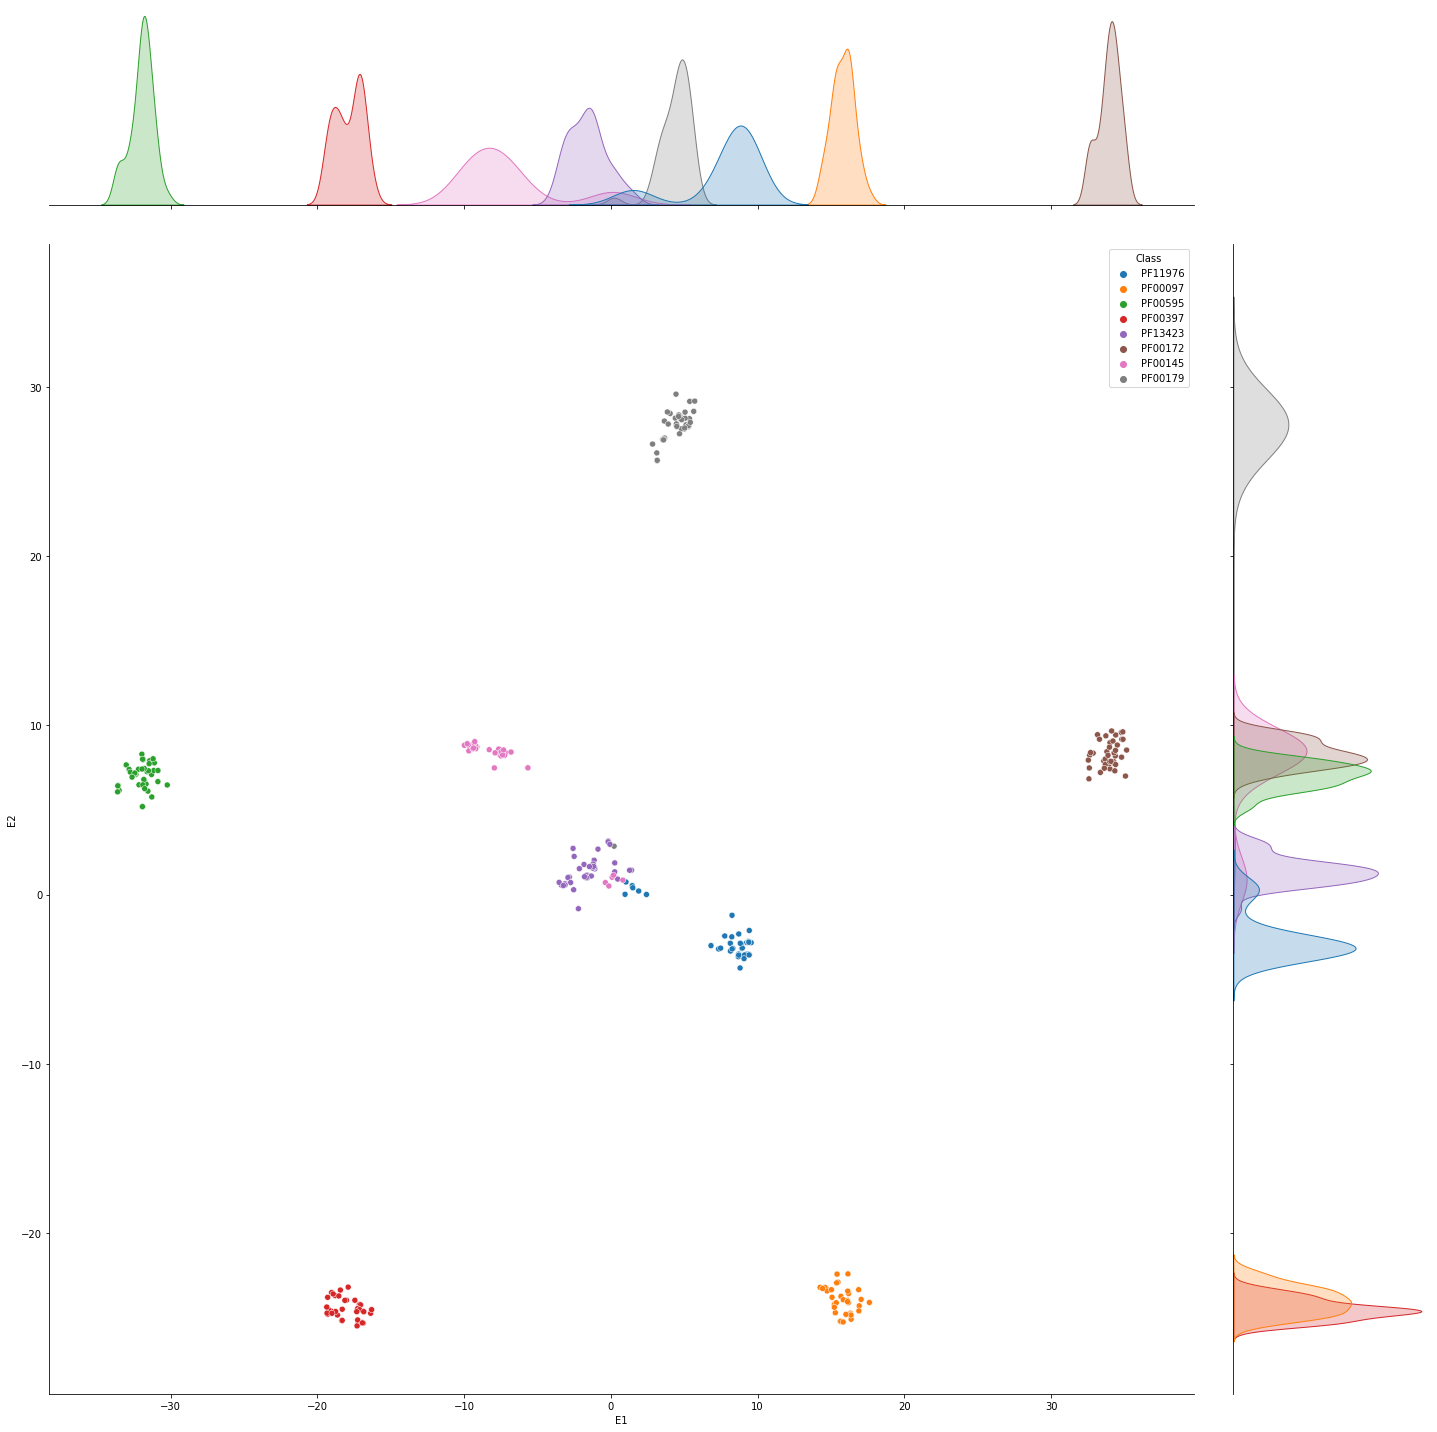

In [ ]:
X_embedded = TSNE(n_components=2,random_state=42).fit_transform(X)

df['E1'] = X_embedded[:,0]
df['E2'] = X_embedded[:,1]

#plt.rcParams.update({'font.size': 10})
sns.jointplot(data=df, x='E1', y='E2', hue = 'Class', height=20)
#sns.jointplot(data=df, x='E1', y='E2', height=10)

In [ ]:
df_new = df[(df.E1.between(0,10)) & (df.E2.between(0,10))]
df_new

NameError: ignored

In [ ]:
X_embedded

array([[ 9.37225151e+00, -3.50894403e+00],
       [ 8.70446205e+00, -3.51018596e+00],
       [ 1.76092377e+01, -2.40956860e+01],
       [-3.14253254e+01,  7.90774822e+00],
       [-1.92918606e+01, -2.47875462e+01],
       [-1.77360803e-01,  3.16674042e+00],
       [ 3.40054169e+01,  7.42848206e+00],
       [ 9.25701141e+00, -2.82563019e+00],
       [ 1.56738052e+01, -2.37343979e+01],
       [-3.35049667e+01,  6.15897036e+00],
       [ 3.50590172e+01,  7.00421715e+00],
       [ 8.86810970e+00, -2.90420890e+00],
       [-1.86290264e+01, -2.48371754e+01],
       [-5.66632366e+00,  7.49771452e+00],
       [ 9.41889286e+00, -3.56406975e+00],
       [ 3.51376152e+01,  8.53960228e+00],
       [-1.83045940e+01, -2.44951725e+01],
       [-3.17879601e+01,  6.74131298e+00],
       [ 1.61196041e+01, -2.39770756e+01],
       [-9.12891197e+00,  8.72942352e+00],
       [ 3.37233543e+01,  9.38035679e+00],
       [ 2.21851453e-01,  1.10496473e+00],
       [-1.60308361e+00,  9.91000295e-01],
       [ 3.

Designed by Yasser MOHSENI BEHBAHANI and Élodie LAINE, LCQB, Sorbonne Université, 2022

<img src='https://drive.google.com/uc?id=1shvaqXgnRa2aCji30gJ02hwI_Ux6NEp6'>